# Parsing Data - Zillow

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import ast
import pandas as pd
import numpy as np
import time
import requests
import pickle
from lxml import html
import unicodecsv as csv
import argparse
from __future__ import print_function, division
import ast
from bs4 import BeautifulSoup
from lxml import html
import requests
import unicodecsv as csv
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#import ml_insights as mli

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
def get_soup(search,p):
    url = "https://www.zillow.com/homes/for_sale/{}_rb/{}_p/".format(search,p)
    headers= {
                        'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                        'accept-encoding':'gzip, deflate, sdch, br',
                        'accept-language':'en-GB,en;q=0.8,en-US;q=0.6,ml;q=0.4',
                        'cache-control':'max-age=0',
                        'upgrade-insecure-requests':'1',
                        'user-agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'
            }
    response = requests.get(url,headers=headers)
    page = response.text
    return BeautifulSoup(page, "lxml")

def get_npage(soup):
    n_page=soup.find(attrs={'class':'zsg-pagination'})
    if n_page==None:
        time.sleep(30)
        n_page = 1
    
    else:
        n_page=str(n_page.text).split("...")
        if len(n_page) > 1:
            n_page=n_page[1]
            n_page=n_page[:-4]
        else:
            n_page=n_page[0]
            n_page=n_page[-5:-4]
    return int(n_page)

def get_info_deep(url):
    headers= {
                        'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                        'accept-encoding':'gzip, deflate, sdch, br',
                        'accept-language':'en-GB,en;q=0.8,en-US;q=0.6,ml;q=0.4',
                        'cache-control':'max-age=0',
                        'upgrade-insecure-requests':'1',
                        'user-agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'
            }
    response = requests.get(url,headers=headers)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    labels = [element for element in soup.find_all(attrs={'class':'fact-label'})]
    facts = {}
    for i in range(len(labels)):
        facts[(labels[i].text).replace("\xa0","")]=labels[i].find_next().text
    return facts

In [3]:
def parse(zipcode,n_page):
    print("parsing zipcode ",zipcode)
    properties_list = []
    pages = np.arange(1,n_page+1)
    
    for p in pages:
        url = "https://www.zillow.com/homes/for_sale/{}_rb/{}_p/".format(zipcode,p)    
        headers= {
                    'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                    'accept-encoding':'gzip, deflate, sdch, br',
                    'accept-language':'en-GB,en;q=0.8,en-US;q=0.6,ml;q=0.4',
                    'cache-control':'max-age=0',
                    'upgrade-insecure-requests':'1',
                    'user-agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'
        }
        response = requests.get(url,headers=headers)
        #print(response.status_code)
        parser = html.fromstring(response.text)
        search_results = parser.xpath("//div[@id='search-results']//article")


        for properties in search_results:
            raw_address = properties.xpath(".//span[@itemprop='address']//span[@itemprop='streetAddress']//text()")
            raw_city = properties.xpath(".//span[@itemprop='address']//span[@itemprop='addressLocality']//text()")
            raw_state= properties.xpath(".//span[@itemprop='address']//span[@itemprop='addressRegion']//text()")
            raw_postal_code= properties.xpath(".//span[@itemprop='address']//span[@itemprop='postalCode']//text()")
            raw_price = properties.xpath(".//span[@class='zsg-photo-card-price']//text()")
            raw_info = properties.xpath(".//span[@class='zsg-photo-card-info']//text()")
            url = properties.xpath(".//a[contains(@class,'overlay-link')]/@href")
            raw_title = properties.xpath(".//h4//text()")
            raw_broker_name = properties.xpath(".//span[@class='zsg-photo-card-broker-name']//text()")

            address = ' '.join(' '.join(raw_address).split()) if raw_address else None
            city = ''.join(raw_city).strip() if raw_city else None
            state = ''.join(raw_state).strip() if raw_state else None
            postal_code = ''.join(raw_postal_code).strip() if raw_postal_code else None
            price = ''.join(raw_price).strip() if raw_price else None
            info = ' '.join(' '.join(raw_info).split()).replace(u"\xb7",',')
            try:
                beds = ''.join(re.match("(.*?)(bd)",info).group().split(' ')[-2:])
            except:
                beds = None
            try: 
                baths = ''.join(re.match("(.*?)(ba)",info).group().split(' ')[-2:])
            except:
                baths = None
            try:
                size = ''.join(re.match("(.*?)((ac)|(sqft))",info).group().split(' ')[-2:])
            except:
                size = None
            property_url = "https://www.zillow.com"+url[0] if url else None
            title = ''.join(raw_title) if raw_title else None
            broker = ''.join(raw_broker_name).strip() if raw_broker_name else None
            
            data= get_info_deep(property_url)
            data['address']=address
            data['city']=city
            data['state']=state
            data['postal_code']=postal_code
            data['price']=price
            data['real estate provider']=broker
            data['url']=property_url
            data['title']=title
            data['beds']=beds if beds else None
            data['baths']=baths if baths else None
            data['size']=size if size else None
            data['facts and features']=info
            properties_list.append(pd.DataFrame(data,index=[0]))

    return properties_list

In [4]:
zipcodes=[80014, 80019, 80022, 80110, 80123, 80201, 80202, 80203, 80204,80205,80206,80207,80208,80209,80210,80211,
80212,80216,80217,80218,80219,80220,80221,80222,80223,80224,80227,80230,80231,80235,80236,80237,80238,80239,80243,
80244,80246,80247,80248,80249,80250,80251,80252,80256,80257,80259,80261,80262,80263,80264,80265,80266,80271,80273,
80274,80281,80290,80291,80293,80294,80295,80299,80330,80640,80642]

In [5]:
info=[]

In [6]:
def get_data(zipcodes):
    info = []
    for code in zipcodes:
        soup = get_soup(code,1)
        n_page=get_npage(soup)
        print(code,n_page)
        info += parse(code,n_page)

    return info

In [7]:
final_info = get_data(zipcodes)

In [8]:
import pickle
with open('final_info.pkl', 'wb') as picklefile:
    pickle.dump(final_info, picklefile)

In [10]:
df = pd.concat(final_info).reset_index()

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [11]:
df['city'].unique()

array(['AURORA', 'Aurora', 'COMMERCE CITY', 'Commerce City', 'ENGLEWOOD',
       'Englewood', 'Denver', 'LITTLETON', 'Bow Mar', 'Lakewood',
       'Littleton', 'DENVER', 'denver', 'Wheat Ridge', 'Thornton',
       'Denver?', 'Cherry Hills Village', 'Henderson', 'HENDERSON',
       'Brighton', 'Hudson', 'HUDSON'], dtype=object)

In [12]:
denver=df[(df['city']=='Denver') | (df['city']=='DENVER')]

In [ ]:
def beds(x):
    try:
        beds = ''.join(re.match("(.*?)(bd)",x).group().split(' ')[-2:])
    except:
        beds = None
    return beds

def baths(x):
    try:
        baths = ''.join(re.match("(.*?)(ba)",x).group().split(' ')[-2:])
    except:
        baths = None
    return baths

def size(x):
    try:
        size = ''.join(re.match("(.*?)((ac)|(sqft))",x).group().split(' ')[-2:])
    except:
        size = None
    return size

denver['beds'] = denver['facts and features'].apply(lambda x: beds(x))
denver['baths'] = denver['facts and features'].apply(lambda x: baths(x))
denver['size'] = denver['facts and features'].apply(lambda x: size(x))

In [13]:
denver = denver.replace('No Data', "")

# Delete rows where price is 0
denver=denver.dropna(subset=['price'])

# Cleaning the data

## Selecting features to model

In [14]:
# Get rid of all the unique or empty variables
columns = []
for col in denver.columns:
    if denver[col].nunique() > 1 and denver[col].isna().sum() < 1000:
        columns.append(col)

In [15]:
for col in denver.columns:
    print(col)

index
1/2 Baths:
1/4 Baths:
3/4 Baths:
Addition size:
Appliances included:
Architectural Style:
Association Fee Frequency Second:
Association Fee Frequency:
Association Fee Includes:
AssociationFeeFrequency_SEARCH:
Attic size:
Basement/Substructure:
Baths Full:
Baths Half:
Baths Quarter:
Baths Three Quarter:
Baths:
Bedroom 2 Level:
Bedroom 3 Level:
Bedroom 4 Level:
Beds:
Building Type:
Built by:
Business Type:
City:
City_SEARCH:
Co List Agent Direct Work Phone:
Co List Agent Email:
Co List Agent Full Name:
Co List Office Name:
Co List Office Phone:
Community name:
Condo Floor Location Type:
Construction Materials:
Construction Methods:
ConstructionStatus_search:
Cooling
Cooling:
County Or Parish:
CountyOrParish_SEARCH:
Days on Zillow
Days on Zillow:
Elementary school:
Exterior Features:
Exterior material:
Family Rm Level:
Features:
Fence_rvalue:
Fireplace Locations:
Floor size:
FloorPlan_search:
Flooring:
Foundation type:
FoundationDetails_rvalue:
Full Baths:
Garage/Carport:
GarageType

In [16]:
# 2 round remove columns with too many empty values
for col in columns:
    if denver[col].isna().sum()>500:
        columns.remove(col)

In [17]:
# Manualy remove duplicated or useless features
rm = ['Price/sqft','Price/sqft:','Beds:','Construction Methods:','Days on Zillow','Days on Zillow:','Floor size:','MLS #:','Last sold:','Lot:','Roof type:','Saves'] #incomplete. I'm gonna recalculate them after
for r in rm:
    columns.remove(r)

In [18]:
for col in columns:
    print(col,denver[col].isna().sum())

Cooling 77
Cooling: 398
Heating 77
Heating: 352
Middle school: 512
Parking 77
Parking: 330
School district: 378
Type 77
Year Built 77
address 0
city 0
facts and features 0
postal_code 0
price 0
real estate provider 403
title 0
url 0


### Type

In [19]:
denver['Type'].value_counts()

Single Family    1431
Condo             758
Townhouse         357
Multi Family       25
Other               2
Apartment           1
Name: Type, dtype: int64

In [20]:
# Unifying Multi Family, Other and Apartment in "Other"
denver['Type']=denver['Type'].apply(lambda x: 'Other' if (x=='Apartment') | (x=='Multi Family') else x)

### Cooling

In [21]:
denver['Cooling:'].value_counts()

Central                                          1351
Ceiling Fan                                       240
None                                              215
Evaporative                                       130
Air Conditioning-Room                             105
Ceiling Fan, Air Conditioning-Room                 51
Other                                              45
Attic Fan                                          41
Wall                                               20
Central, Evaporative                               15
Ceiling Fan, Attic Fan                             14
Central, Other                                     13
Central, Solar                                      3
Attic Fan, Air Conditioning-Room                    2
Evaporative, Wall                                   2
Evaporative, None                                   2
Evaporative, Other                                  1
Central, Refrigeration                              1
Ceiling Fan, Attic Fan, Air 

In [22]:
def cooling1(x):
    if x == 'nan':
        return ''
    elif "Air" in x:
        return "Air Conditioning"
    elif "Central" in x:
        return "Central"
    elif "Fan" in x:
        return "Fan"
    elif "Evaporative" in x:
        return "Evaporative"
    elif "Wall" in x:
        return "Other"
    elif "None" in x:
        return "No cooling"

In [23]:
denver['Cooling1']=denver['Cooling:'].astype('str').apply(lambda x: cooling1(x))

In [24]:
denver['Cooling1'].value_counts()

Central             1384
                     398
Fan                  295
No cooling           215
Air Conditioning     159
Evaporative          135
Other                 20
Name: Cooling1, dtype: int64

In [25]:
def cooling2(x):
    if x == 'nan':
        return ''
    elif 'Central' in x:
        return 'Central'
    else:
        return 'No Central'
    

In [26]:
denver['Cooling2']=denver['Cooling:'].astype('str').apply(lambda x: cooling2(x))

In [27]:
denver['Cooling2'].value_counts()

Central       1384
No Central     869
               398
Name: Cooling2, dtype: int64

### Heating

In [28]:
def heating(x):
    if x == 'nan':
        return ''
    elif 'Gas' in x:
        return 'Gas'
    else:
        return 'Other'

In [29]:
denver['Heating2']=denver['Heating:'].astype('str').apply(lambda x: heating(x))

In [30]:
#columns.remove('Heating')
denver['Heating2'].value_counts()

Gas      1764
Other     535
          352
Name: Heating2, dtype: int64

### Parking:

In [31]:
#denver['Parking:'].value_counts()

In [32]:
denver['Parking1'] = denver['Parking:'].replace(r'.*(street).*',"0", regex=True)
denver['Parking1'] = denver['Parking1'].replace(r'(space).*',"", regex=True)
denver['Parking1'] = denver['Parking1'].replace(r'[0-9]+( sqft)',"",regex=True)
denver['Parking1'] = denver['Parking1'].replace(r'[^0-9]+',"",regex=True)
denver['Parking1'] = denver['Parking1'].replace(r'^\s*$', np.nan, regex=True)
denver['Parking1'] = denver['Parking1'].astype('float')

In [33]:
denver['Parking1'].value_counts()

2.00      1064
1.00       513
0.00       335
3.00       158
4.00        86
6.00        22
5.00        19
8.00         7
7.00         7
10.00        3
11.00        3
12.00        3
50.00        2
21.00        2
9.00         2
13.00        1
16.00        1
30.00        1
15.00        1
56.00        1
44.00        1
40.00        1
135.00       1
Name: Parking1, dtype: int64

In [34]:
denver['Parking1'].isnull().sum()

417

In [35]:
def parking(x):
    if x!="":
        if x > 2:
            return 3
        else:
            return x


In [36]:
denver['Parking2']=denver['Parking1'].apply(lambda x: parking(x))

In [37]:
denver['Parking2'] = denver['Parking2'].replace('nan',np.nan,regex=True).astype('float')


In [38]:
denver['Parking2'].value_counts()

2.00    1064
1.00     513
0.00     335
3.00     322
Name: Parking2, dtype: int64

In [39]:
denver['Parking2'].isnull().sum()

417

### School district

In [40]:
denver['School district:'].value_counts()

#denver[denver['School district:']=='DENVER'][['Elementary school:','High school:','Middle school:','School district:','address']]

Denver 1                              1983
Denver PSD 1                            92
Cherry Creek 5                          56
Westminster Public Schools              49
Denver District 1                       40
Mapleton R-1                            16
DENVER                                   6
Denver Public Schools                    6
Adams 12 5 Star Schl                     4
Denver                                   4
DENVER 1                                 3
Jefferson County R-1                     2
Denv                                     2
Adams-Arapahoe 28J                       2
Adams 12                                 1
Sheridan 2                               1
Adams 14                                 1
Denver Public Schools - K - 8 Team       1
CHERRY CREEK                             1
DENVER PUBLIC SCHOOL DISTRICT 1          1
Bromwell                                 1
Jefferson R-1                            1
Name: School district:, dtype: int64

In [41]:
dist=denver['School district:'].unique()

In [42]:
correct=['Denver County 1 School District','nan','Denver County 1 School District','Denver County 1 School District',
         'Denver County 1 School District','Denver County 1 School District','Denver County 1 School District',
         'Denver County 1 School District','Denver County 1 School District','Denver County 1 School District',
'Westminster 50 School District', 'Jefferson County R-1 School District','Jefferson County R-1 School District',
'Adams 12 Five Star Schools School District', 'Bromwell','Adams-Arapahoe 28j School District',
'Mapleton Public Schools Adams County School District 1', 'Adams 12 Five Star Schools School District','Adams County 14 School District',
'Cherry Creek 5 School District','Sheridan 2 School District','Denver County 1 School District',
'Cherry Creek 5 School District']

In [43]:
d_names={'School district:':dist,'District':correct}
d_names=pd.DataFrame(d_names)

In [44]:
with open("dist_rank.pkl", 'rb') as picklefile: 
    dist_rank= pickle.load(picklefile)

In [45]:
denver=denver.merge(d_names,how='outer',on='School district:')

In [46]:
denver = denver.merge(dist_rank,how='outer',on='District')

In [47]:
denver['Rank'].unique()

array(['5', nan, '4', '3', '7', '6', '9'], dtype=object)

In [48]:
denver['Rank']=denver['Rank'].astype('float')

### Numerical features

In [49]:
denver['price']=denver['price'].str.replace('K','000')

In [53]:
denver['beds']=denver['beds'].str.replace("Studio","1")

In [54]:
denver['price']=denver['price'].replace(r'[^0-9]+', "", regex=True)
denver['beds']=denver['beds'].replace(r'[^0-9]+', "", regex=True)
denver['baths']=denver['baths'].replace(r'[^0-9]+', "", regex=True)
denver['size']=denver['size'].replace(r'[^0-9]+', "", regex=True)
denver['Year Built']=denver['Year Built'].replace(r'[^0-9]+', "", regex=True)

In [55]:
denver['price']=denver['price'].replace(r'^\s*$', np.nan, regex=True)
denver['beds']=denver['beds'].replace(r'^\s*$', np.nan, regex=True)
denver['baths']=denver['baths'].replace(r'^\s*$', np.nan, regex=True)
denver['size']=denver['size'].replace(r'^\s*$', np.nan, regex=True)
denver['Year Built']=denver['Year Built'].replace(r'^\s*$', np.nan, regex=True)

In [56]:
denver['price']=denver['price'].astype('float')
denver['beds']=denver['beds'].astype('float')
denver['baths']=denver['baths'].astype('float')
denver['size']=denver['size'].astype('float')
denver['Year Built']=denver['Year Built'].astype('float')

In [57]:
denver['Parking2']=denver['Parking2'].replace(r'nan', np.nan, regex=True)
denver['Cooling2']=denver['Cooling2'].replace('',np.nan)

In [59]:
# Removing price outliers 
# denver = denver[(denver['price']<2000000) & (denver['price']>100000)]
# denver = denver[(denver['Parking1']<30)]

# Removing extreme and mostly wrong values of beds and baths
denver=denver[(denver['beds']<10)&(denver['baths']<10)]

In [60]:
with open('denver.pkl', 'wb') as picklefile:
    pickle.dump(denver, picklefile)

# -->  Continues in file 'Modeling'
----------
-------

# Models not used

/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


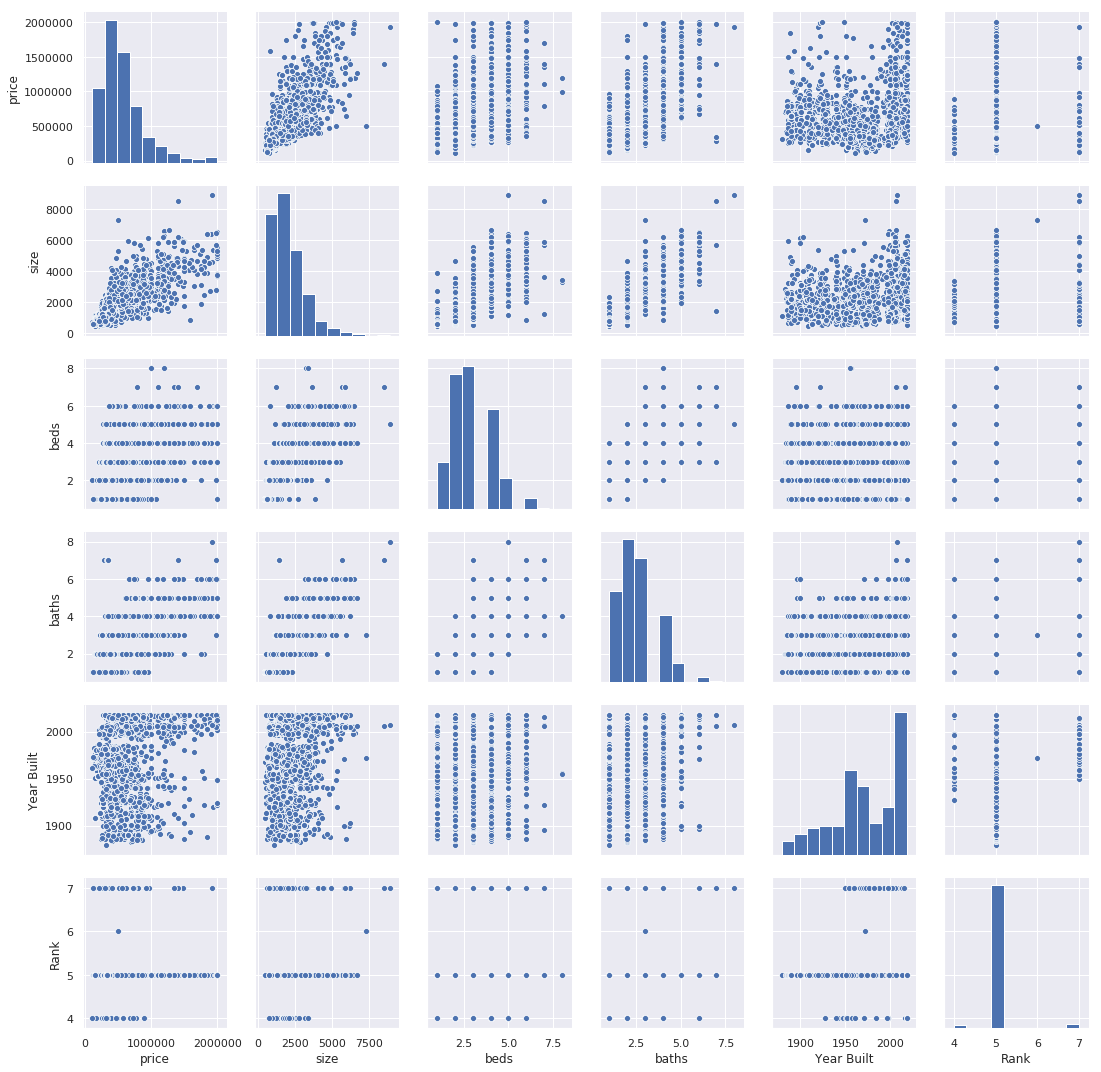

In [1283]:
sns.pairplot(denver[['price','size','beds','baths','Year Built','Rank','Parking2']])

In [735]:
denver[['price','size','beds','baths','Year Built']].sort_values(by='baths', ascending=False)

,price,size,beds,baths,Year Built
1799,322000.00,958.00,1.00,15.00,2001.00
2963,1925000.00,8861.00,5.00,8.00,2007.00
3618,347120.00,1415.00,3.00,7.00,nan
3616,341580.00,1415.00,3.00,7.00,nan
3615,340270.00,1415.00,3.00,7.00,nan
3614,348975.00,1415.00,3.00,7.00,nan
2951,1400000.00,8492.00,7.00,7.00,2006.00
1601,1975000.00,5681.00,6.00,7.00,2018.00
3577,289900.00,1415.00,3.00,7.00,2018.00
665,1250000.00,7735.00,4.00,7.00,1997.00


In [93]:
m1 = denver[['size','price']]

m1=m1.dropna(subset=['size'])

In [94]:
X, y = m1.drop('price',axis=1), m1['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3) #hold out 20% for validation

In [95]:
#Reshaping into 2 dimensional arrays

X_train = X_train.values.reshape(-1,1)
X_val = X_val.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

#set up the 3 models we're choosing from:

lm = LinearRegression()


#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()

In [753]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_poly, poly.fit_transform(X), y, cv=kf, scoring='r2')))

0.549380865736
0.549380870365
0.548262313747


In [754]:
m2 = denver[['size','price','beds','baths','Year Built']]

In [755]:
m2=m2.dropna()

In [756]:
X, y = m2.drop('price',axis=1), m2['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3) #hold out 20% for validation

#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()

In [757]:
lm.fit(X_train, y_train)
print('Linear Regression val R^2: %.3f', lm.score(X_val, y_val))

lm_reg.fit(X_train, y_train)
print('Ridge Regression val R^2: %.3f', lm_reg.score(X_val_scaled, y_val))

lm_poly.fit(X_train_poly, y_train)
print('Degree 2 polynomial regression val R^2: %.3f', lm_poly.score(X_val_poly, y_val))

Linear Regression val R^2: %.3f 0.574896911138
Ridge Regression val R^2: %.3f -19.2289195764
Degree 2 polynomial regression val R^2: %.3f 0.58536153207


In [758]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_poly, poly.fit_transform(X), y, cv=kf, scoring='r2')))

0.588573932499
0.588577339078
0.616028958584


In [759]:
m2['price'].describe()

count      2268.00
mean     576709.54
std      338901.17
min      111000.00
25%      339900.00
50%      499000.00
75%      700000.00
max     1999950.00
Name: price, dtype: float64

In [892]:
m3 = denver[['size','price','beds','baths','Year Built','Rank']].dropna()

In [893]:
X, y = m3.drop('price',axis=1), m3['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3) #hold out 20% for validation

#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()

In [894]:
lm.fit(X_train, y_train)
print('Linear Regression val R^2: %.3f', lm.score(X_val, y_val))

lm_reg.fit(X_train, y_train)
print('Ridge Regression val R^2: %.3f', lm_reg.score(X_val_scaled, y_val))

lm_poly.fit(X_train_poly, y_train)
print('Degree 2 polynomial regression val R^2: %.3f', lm_poly.score(X_val_poly, y_val))

Linear Regression val R^2: %.3f 0.593849253145
Ridge Regression val R^2: %.3f -16.6184313819
Degree 2 polynomial regression val R^2: %.3f 0.609709208062


In [895]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_poly, poly.fit_transform(X), y, cv=kf, scoring='r2')))

0.619400820544
0.619402691614
0.645921819106


In [919]:
m4 = denver[['size','price','beds','baths','Year Built','Rank','Type']].dropna()

In [920]:
m4 = pd.get_dummies(m4)

In [921]:
X, y = m4.drop('price',axis=1), m4['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3) #hold out 20% for validation

#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()

/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [922]:
lm.fit(X_train, y_train)
print('Linear Regression val R^2: %.3f', lm.score(X_val, y_val))

lm_reg.fit(X_train, y_train)
print('Ridge Regression val R^2: %.3f', lm_reg.score(X_val_scaled, y_val))

lm_poly.fit(X_train_poly, y_train)
print('Degree 2 polynomial regression val R^2: %.3f', lm_poly.score(X_val_poly, y_val))

Linear Regression val R^2: %.3f 0.602299589208
Ridge Regression val R^2: %.3f -25.4272222494
Degree 2 polynomial regression val R^2: %.3f 0.623663884441


In [923]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_poly, poly.fit_transform(X), y, cv=kf, scoring='r2')))

0.621137554907
0.621179730714
0.651078715297


In [1140]:
m5 = denver[['size','price','beds','baths','Year Built','Rank','Parking2','Type']].dropna()
m5 = pd.get_dummies(m5)
X, y = m5.drop('price',axis=1), m5['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3) #hold out 20% for validation

#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()

/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.


In [1141]:
lm.fit(X_train, y_train)
print('Linear Regression val R^2: %.3f', lm.score(X_val, y_val))

lm_reg.fit(X_train, y_train)
print('Ridge Regression val R^2: %.3f', lm_reg.score(X_val_scaled, y_val))

lm_poly.fit(X_train_poly, y_train)
print('Degree 2 polynomial regression val R^2: %.3f', lm_poly.score(X_val_poly, y_val))

Linear Regression val R^2: %.3f 0.6519672824
Ridge Regression val R^2: %.3f -52.9868845871
Degree 2 polynomial regression val R^2: %.3f 0.656102104797


In [1142]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_poly, poly.fit_transform(X), y, cv=kf, scoring='r2')))

0.621822838112
0.621867754306
0.675679957352


In [1143]:
m5.head()

,size,price,beds,baths,Year Built,Rank,Parking2_0.0,Parking2_1.0,Parking2_2.0,Parking2_3+,Type_Condo,Type_Other,Type_Single Family,Type_Townhouse
0,3064.00,599000.00,4.00,4.00,1997.00,5.00,0,0,1,0,0,0,1,0
1,2525.00,448000.00,4.00,4.00,1995.00,5.00,0,0,0,1,0,0,1,0
2,1036.00,280000.00,2.00,2.00,2001.00,5.00,0,0,1,0,1,0,0,0
3,1019.00,335000.00,3.00,1.00,1977.00,5.00,0,1,0,0,0,0,1,0
4,2478.00,485000.00,3.00,3.00,1998.00,5.00,0,0,1,0,0,0,1,0


In [1229]:
m6 = denver[['size','price','beds','baths','Year Built','Rank','Parking2','Type','Cooling2']].dropna()
m6 = pd.get_dummies(m6)
X, y = m6.drop('price',axis=1), m6['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3) #hold out 20% for validation

#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()

/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.


In [1230]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_poly, poly.fit_transform(X), y, cv=kf, scoring='r2')))

0.626875427164
0.626920992826
0.687318002068


In [1231]:
m6.corr()

,size,price,beds,baths,Year Built,Rank,Parking2_0.0,Parking2_1.0,Parking2_2.0,Parking2_3+,Type_Condo,Type_Other,Type_Single Family,Type_Townhouse,Cooling2_Central,Cooling2_No Central
size,1.00,0.77,0.72,0.80,0.17,0.07,-0.05,-0.38,0.22,0.21,-0.42,-0.03,0.36,0.03,0.18,-0.18
price,0.77,1.00,0.52,0.70,0.12,-0.00,-0.05,-0.30,0.20,0.13,-0.28,-0.02,0.18,0.11,0.24,-0.24
beds,0.72,0.52,1.00,0.62,-0.02,-0.03,-0.03,-0.38,0.17,0.25,-0.54,0.01,0.54,-0.09,0.03,-0.03
baths,0.80,0.70,0.62,1.00,0.39,0.06,-0.09,-0.35,0.30,0.09,-0.36,-0.03,0.12,0.29,0.27,-0.27
Year Built,0.17,0.12,-0.02,0.39,1.00,0.05,-0.24,-0.00,0.25,-0.12,0.09,-0.03,-0.35,0.36,0.31,-0.31
Rank,0.07,-0.00,-0.03,0.06,0.05,1.00,0.01,0.02,-0.02,-0.01,0.06,0.04,-0.07,0.02,0.04,-0.04
Parking2_0.0,-0.05,-0.05,-0.03,-0.09,-0.24,0.01,1.00,-0.23,-0.39,-0.16,-0.00,-0.00,0.05,-0.07,-0.09,0.09
Parking2_1.0,-0.38,-0.30,-0.38,-0.35,-0.00,0.02,-0.23,1.00,-0.54,-0.22,0.41,-0.02,-0.32,-0.06,-0.00,0.00
Parking2_2.0,0.22,0.20,0.17,0.30,0.25,-0.02,-0.39,-0.54,1.00,-0.38,-0.22,0.02,0.05,0.20,0.11,-0.11
Parking2_3+,0.21,0.13,0.25,0.09,-0.12,-0.01,-0.16,-0.22,-0.38,1.00,-0.19,-0.00,0.28,-0.15,-0.06,0.06


In [1227]:
model = sm.OLS(y_train,X_train)
fit = model.fit()
fit.summary() # This is the advantage of stats model vs sklearn

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     167.7
Date:                Tue, 09 Oct 2018   Prob (F-statistic):          1.22e-225
Time:                        14:51:32   Log-Likelihood:                -15033.
No. Observations:                1104   AIC:                         3.009e+04
Df Residuals:                    1092   BIC:                         3.015e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
size                 188.7442     10.314     18.300      0.000     168.507     208.981
beds               -3.178e+04   8446.608     -3.763      0.000   -4.84e+04   -1.52e+04
baths               9.086e+04   1.01e+04      8.980      0.000     7.1e+04    1.11e+05
Year Built         -1438.9405    199.969     -7.196      0.000   -1831.308   -1046.573
Rank               -5.232e+04   1.79e+04     -2.925      0.004   -8.74e+04   -1.72e+04
Parking2_0.0        1.563e+06   1.98e+05      7.889      0.000    1.17e+06    1.95e+06
Parking2_1.0        1.571e+06   2.02e+05      7.790      0.000    1.18e+06    1.97e+06
Parking2_2.0        1.589e+06   2.02e+05      7.868      0.000    1.19e+06    1.99e+06
Parking2_3+         1.582e+06   2.01e+05      7.873      0.000    1.19e+06    1.98e+06
Type_Condo          1.615e+06   2.02e+05      8.003      0.000    1.22e+06    2.01e+06
Type_Other          1.532e+06   2.18e+05      7.030      0.000     1.1e+06    1.96e+06
Type_Single Family  1.541e+06   1.98e+05      7.803      0.000    1.15e+06    1.93e+06
Type_Townhouse      1.617e+06   2.03e+05      7.955      0.000    1.22e+06    2.02e+06
==============================================================================
Omnibus:                      207.622   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              674.430
Skew:                           0.911   Prob(JB):                    3.54e-147
Kurtosis:                       6.368   Cond. No.                     3.87e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.54e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1194]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    s=len(x)
    rgr = LinearRegression()
    rgr.fit(x.values.reshape(s,1),y)
    pred = rgr.predict(x.values.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

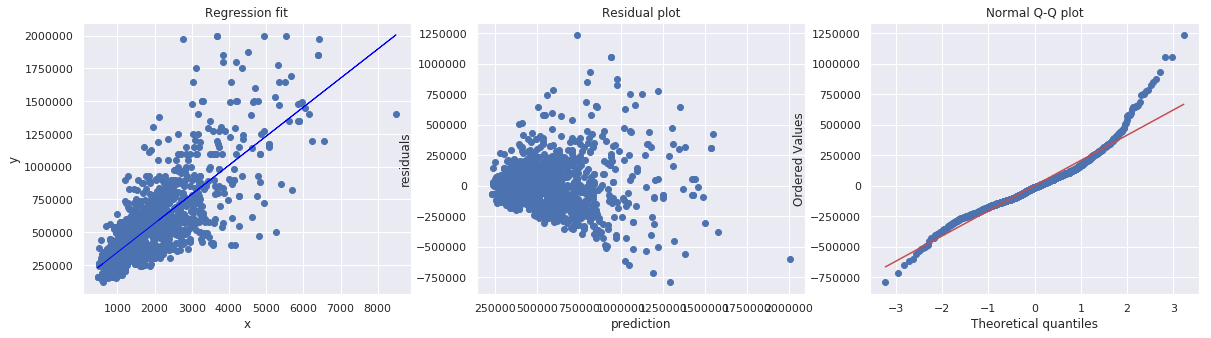

In [1200]:
diagnostic_plot(X_train['size'],y_train)

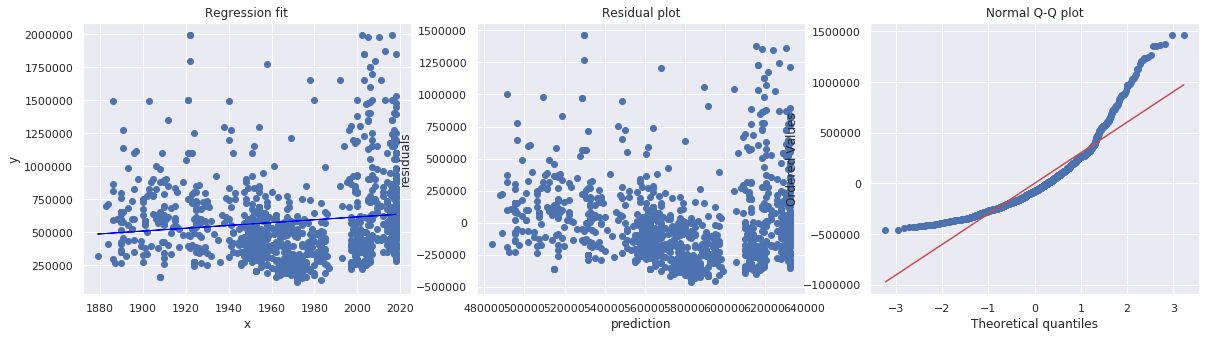

In [1196]:
diagnostic_plot(X_train['Year Built'],y_train)

In [1210]:
m7=m6[:]
m7['Year2']=m7['Year Built']**2

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1211]:
m7.head()

,size,price,beds,baths,Year Built,Rank,Parking2_0.0,Parking2_1.0,Parking2_2.0,Parking2_3+,Type_Condo,Type_Other,Type_Single Family,Type_Townhouse,Cooling2_Central,Cooling2_No Central,Year2
0,3064.00,599000.00,4.00,4.00,1997.00,5.00,0,0,1,0,0,0,1,0,0,1,3988009.00
1,2525.00,448000.00,4.00,4.00,1995.00,5.00,0,0,0,1,0,0,1,0,0,1,3980025.00
2,1036.00,280000.00,2.00,2.00,2001.00,5.00,0,0,1,0,1,0,0,0,0,1,4004001.00
3,1019.00,335000.00,3.00,1.00,1977.00,5.00,0,1,0,0,0,0,1,0,0,1,3908529.00
4,2478.00,485000.00,3.00,3.00,1998.00,5.00,0,0,1,0,0,0,1,0,1,0,3992004.00


In [1218]:
X, y = m7.drop('price',axis=1), m7['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3) #hold out 20% for validation

#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [1219]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X_scaled, y, cv=kf, scoring='r2')))

0.637259410302
